In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

# Model evaluation related packages
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error


# Surprise libray related packages
from surprise import Reader, Dataset
from surprise import BaselineOnly 
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp

# XGB Models
from xgboost import XGBRegressor
import xgboost

#
from prettytable import PrettyTable

# Configs

In [3]:
sample_size = -1 # set -1 if you want to use full size

df_train_path = './data/Final_Train.csv'
df_test_path =  './data/Final_Test.csv'

# UTIL functions

In [4]:
def get_ratings(predictions):
    
    # get the actual labels
    actual = np.array([pred.r_ui for pred in predictions])
    
    # get the predicted labels
    pred = np.array([pred.est for pred in predictions])
    
    return (actual, pred,)

In [5]:
def compute_mape(actual, predicted):

    # compute MAPE error
    try:
        mape = np.mean(abs(actual - predicted)/actual)
    except ZeroDivisionError:
        print('Division by zero error in MAPE')
        mape = np.inf
    except:
        print('Exception in computing MAPE value')
        mape = np.inf
    
    # get percentage value & return
    return mape * 100

In [6]:
def evaluate_model(model, X, y, prefix=str()):
    
    # get predicted values
    pred_values = model.predict(X)
    
    # compute mean squared error
    mse = mean_squared_error(y, pred_values)
    
    # compute mape
    mape = compute_mape(y, pred_values)
    
    # round off the value to 4 decimal places
    mse = round(mse, 4)
    mape = round(mape, 4)
    
    print(prefix + ' -> MSE:%f \t MAPE:%f'%(mse, mape,))
    
    return (mse, mape,)

# Data

In [7]:
# read the dataframes
df_train = pd.read_csv(df_train_path, index_col=False)
df_test = pd.read_csv(df_test_path, index_col=False)

# sort the records by date
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d')

# sort the datafrmaes in ascending order of timestamp
df_train = df_train.sort_values(['date'], ascending=True)
df_train = df_train.reset_index(drop=True)
df_test = df_test.sort_values(['date'], ascending=True)
df_test = df_test.reset_index(drop=True)

# sample the dataframe
if sample_size > 0:
    df_train = df_train.iloc[0:sample_size,] 
    df_test = df_test.iloc[0:sample_size,] 
    
print('Shape of train df :', df_train.shape)
print('Shape of test df :', df_test.shape)

Shape of train df : (696736, 17)
Shape of test df : (174185, 17)


In [8]:
df_train.head()

,date,user,movie,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,Gavg,UAvg,MAvg,rating
0,1999-11-11,510180,2866,3,3,3,3,3,3,3,5,3,4,3.586035,3.44,3.230769,3
1,1999-11-11,510180,3870,3,3,1,3,3,3,3,3,3,3,3.586035,3.44,3.145320,2
2,1999-11-11,510180,14660,3,3,2,1,3,1,3,3,3,4,3.586035,3.44,3.000000,2
3,1999-11-11,510180,11234,3,3,3,3,3,3,2,3,5,1,3.586035,3.44,3.555556,5
4,1999-12-06,510180,9536,4,4,4,4,4,3,2,3,2,5,3.586035,3.44,4.000000,5


In [9]:
df_test.tail()

,date,user,movie,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,Gavg,UAvg,MAvg,rating
174180,2005-12-31,1088143,10729,3.586035,3.586035,3.586035,3.586035,3.586035,4.193548,4.045793,3.968914,3.838843,4.018973,3.586035,3.586035,3.943820,3
174181,2005-12-31,1427836,6386,3.586035,3.586035,3.586035,3.586035,3.586035,3.585621,3.409039,3.256491,3.690944,3.823619,3.586035,3.586035,3.255159,4
174182,2005-12-31,1427836,13651,3.586035,3.586035,3.586035,3.586035,3.586035,3.409039,3.690944,3.741748,3.765557,3.330142,3.586035,3.586035,3.692144,4
174183,2005-12-31,1427836,2913,3.586035,3.586035,3.586035,3.586035,3.586035,4.328924,3.589595,4.145440,3.374704,4.416130,3.586035,3.586035,4.045169,4
174184,2005-12-31,239139,12034,3.586035,3.586035,3.586035,3.586035,3.586035,4.134667,3.645894,3.954266,4.391037,4.128524,3.586035,3.586035,4.080811,3


In [10]:
# Extract features and labels separately
X_train = df_train.drop(['date', 'user', 'movie', 'Gavg', 'rating'], axis=1)
y_train = df_train['rating']

X_test = df_test.drop(['date', 'user', 'movie', 'Gavg', 'rating'], axis=1)
y_test = df_test['rating']

In [11]:
X_test.head()

,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg
0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.500000,3.409039
1,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.978261,3.821851
2,4.0,4.0,4.0,5.0,4.0,5.0,2.0,2.0,5.0,2.0,2.978261,4.080811
3,3.0,4.0,2.0,3.0,3.0,3.0,4.0,4.0,5.0,4.0,4.000000,3.617293
4,2.0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.914894,2.854015


# A) Surprise Library Models

In [12]:
def run_surprise_model(algo, train_df, test_df, verbose=True): 
    """
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    """
    
    
    reader = Reader(rating_scale=(1,5))

    # create the traindata from the dataframe...
    train_data = Dataset.load_from_df(train_df[['user', 'movie', 'rating']], reader)
    test_data = Dataset.load_from_df(test_df[['user', 'movie', 'rating']], reader)

    # build the trainset from traindata.., It is of dataset format from surprise library..
    trainset = train_data.build_full_trainset()
    testset = test_data.build_full_trainset()
    
    # dictionaries that stores metrics for train and test..
    evaluation_dict = dict()
    

    # ==================== Train Stage ===================================
    print(datetime.now(), 'Training Stage ...')
    # fit to data
    algo.fit(trainset)
    # predict on train data set 
    train_pred_tuples = algo.test(trainset.build_testset())
    # get the mean squared error & mape
    actual, predicted = get_ratings(train_pred_tuples)
    mse = mean_squared_error(actual, predicted)
    mape = compute_mape(actual, predicted)
    
    # round off values upto 4 decimal places
    mse = round(mse, 4)
    mape = round(mape, 4)
    
    evaluation_dict['train'] = {'mse':mse, 'mape':mape, 'predictions':predicted}
    print(datetime.now(), 'Training Stage Done !!!')
    
    
    # ==================== Evaluating Test data ==========================
    
    print(datetime.now(), 'Test Stage ...')
    
    # predict on train data set 
    test_pred_tuples = algo.test(testset.build_testset())
    # get the mean squared error & mape
    actual, predicted = get_ratings(test_pred_tuples)
    mse = mean_squared_error(actual, predicted)
    mape = compute_mape(actual, predicted)
    
    # round off values upto 4 decimal places
    mse = round(mse, 4)
    mape = round(mape, 4)
    
    evaluation_dict['test'] = {'mse':mse, 'mape':mape, 'predictions':predicted}
    print(datetime.now(), 'Testing Stage Done !!!')
    
    
    print('---------------------- Evaluation results --------------------')
    print('Train data : MSE:%f, MAPE:%f'%(evaluation_dict['train']['mse'], 
                                          evaluation_dict['train']['mape'],))
    print('Test data : MSE:%f, MAPE:%f'%(evaluation_dict['test']['mse'], 
                                          evaluation_dict['test']['mape'],))
    
    return evaluation_dict

## A1) Surprise BaselineOnly Model

In [13]:
# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': 0.001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)

In [14]:
results_dict_bsl = run_surprise_model(bsl_algo, df_train, df_test)

2019-06-25 10:36:20.107312 Training Stage ...
Estimating biases using sgd...
2019-06-25 10:36:27.842645 Training Stage Done !!!
2019-06-25 10:36:27.842908 Test Stage ...
2019-06-25 10:36:29.007775 Testing Stage Done !!!
---------------------- Evaluation results --------------------
Train data : MSE:0.861500, MAPE:28.872600
Test data : MSE:1.045800, MAPE:32.111800


## A2) Surprise KNN Base Line Model

In [15]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}

# create model object
knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

In [16]:
results_dict_knn_bsl_u = run_surprise_model(knn_bsl_u, df_train, df_test)

2019-06-25 10:36:30.523481 Training Stage ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
2019-06-25 11:04:15.379397 Training Stage Done !!!
2019-06-25 11:04:15.395576 Test Stage ...
2019-06-25 11:06:17.264291 Testing Stage Done !!!
---------------------- Evaluation results --------------------
Train data : MSE:0.201900, MAPE:12.744700
Test data : MSE:1.029900, MAPE:31.580100


In [17]:
sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}

# create model object
knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

In [18]:
results_dict_knn_bsl_m = run_surprise_model(knn_bsl_m, df_train, df_test)

2019-06-25 11:06:31.133016 Training Stage ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
2019-06-25 11:07:55.231868 Training Stage Done !!!
2019-06-25 11:07:55.231948 Test Stage ...
2019-06-25 11:08:03.424434 Testing Stage Done !!!
---------------------- Evaluation results --------------------
Train data : MSE:0.247800, MAPE:14.042600
Test data : MSE:1.064300, MAPE:31.723400


## A3) Surprise Model SVD

In [19]:
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)

In [20]:
results_dict_svd = run_surprise_model(svd, df_train, df_test)

2019-06-25 11:08:05.272483 Training Stage ...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
2019-06-25 11:08:44.433132 Training Stage Done !!!
2019-06-25 11:08:44.433227 Test Stage ...
2019-06-25 11:08:46.039565 Testing Stage Done !!!
---------------------- Evaluation results --------------------
Train data : MSE:0.454300, MAPE:20.095700
Test data : MSE:1.033400, MAPE:31.385700


## A4) Surprise Model SVDpp

In [21]:
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)

In [22]:
results_dict_svdpp = run_surprise_model(svdpp, df_train, df_test)

2019-06-25 11:08:47.677612 Training Stage ...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
2019-06-25 11:34:40.168822 Training Stage Done !!!
2019-06-25 11:34:40.168915 Test Stage ...
2019-06-25 11:34:47.404024 Testing Stage Done !!!
---------------------- Evaluation results --------------------
Train data : MSE:0.436400, MAPE:19.367800
Test data : MSE:1.035500, MAPE:31.128500


# B) XGB Model

In [23]:
def get_best_hyperparam_XGBRegressor(param_dict, X, y, random_search=False):
    
    # set the scoring function
    final_scorer = 'MAPE'
    
    # declare a scoring dictionary
    score_dict = {
        'MAPE': make_scorer(score_func=compute_mape, greater_is_better=False,
                                     needs_proba=False, needs_threshold=False),
        'MSE' : make_scorer(score_func=mean_squared_error, greater_is_better=False,
                                     needs_proba=False, needs_threshold=False)
    }
    
     #Declare the metric as  'minimization' or 'maximization'
    optimization_dict = {
        'MAPE' : 'minimization',
        'MSE' : 'minimization'
    }
    
    # Time Series split
    cv_data = TimeSeriesSplit(n_splits=3)
    
    # =========================================================================================
        
     
    # declare model
    model = XGBRegressor()
    
    if random_search:
        search_cv = RandomizedSearchCV(estimator=model, param_distribution=param_dict, 
                                       cv=cv_data, scoring=score_dict, refit=False, 
                                       return_train_score=True, n_iter=6, n_jobs=-1)
        
    else:
        # declare grid search CV object
        search_cv = GridSearchCV(estimator=model, param_grid=param_dict, cv=cv_data,
                                 scoring=score_dict, refit=False, 
                                 return_train_score=True, n_jobs=-1)
    
    # fit to the data
    search_cv.fit(X, y)
    
    
    # get total number of param settings
    param_list = list(param_dict.keys())
    param_field_list = ['param_' + item for item in param_list]
    
    # get list of train metric list
    train_metric_list = ['mean_train_' + item for item in score_dict.keys()]
    # get list of test metric list
    test_metric_list = ['mean_test_' + item for item in score_dict.keys()]
    
    # get number of rows in the search cv data frame
    num_rows = len(search_cv.cv_results_['params'])
        
    # create the grid search info df  
    grid_info_df = pd.DataFrame(search_cv.cv_results_, index=range(num_rows))
    
    # prepare a list of reqired columns
    required_columns = ['params'] + param_field_list + train_metric_list + \
                       test_metric_list
    
    # slice the data frame to only required columns
    grid_info_df = grid_info_df[required_columns]
    
    # process individual metrics
    for metric, optimization in optimization_dict.items():
        if optimization == 'minimization':
            grid_info_df['mean_train_' + metric] *= -1
            grid_info_df['mean_test_' + metric] *= -1
            
    # Find the best hyperparam & its corresponding scores
    if optimization_dict[final_scorer] == 'minimization':
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmin(),:] 
    else:
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmax(),:]
        
    # best hyperparam & corresponding scores
    best_hyperparam = best_hyperparam_record['params']
    best_train_score = best_hyperparam_record['mean_train_'+ final_scorer]
    best_validation_score = best_hyperparam_record['mean_test_'+ final_scorer]
    
    # plot the hyper params 
    if len(param_list) == 1:
        # extract individual fiedls
        x_vals = grid_info_df[param_field_list[0]].tolist()
        y_vals_tr = grid_info_df['mean_train_' + final_scorer].tolist()
        y_vals_val = grid_info_df['mean_test_' + final_scorer].tolist()
        
        # plot train, validation performances
        plt.plot(x_vals, y_vals_tr, label='Train', color='r', marker='o', linestyle='-')
        plt.plot(x_vals, y_vals_val, label='Validation', color='b', marker='o', linestyle='-')
        plt.xlabel('Hyper Params -' + param_list[0])
        plt.ylabel(final_scorer)
        plt.legend()
        plt.title('XGB Regression - Hyperparam Train v/s Validation Scores')
        plt.show()
        
    # Heatmap plot for pair of hyperparam values  
    elif len(param_list) == 2:
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_train_' + final_scorer , 
                                      fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('XGB Regression - Hyperparams Scores - Train')
        plt.show()
        
        print('\n'*3)
        
        # Test hyperparam
        
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_test_' + final_scorer, fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('XGB Regression - Hyperparams Scores - Validation')
        plt.show()
    
    else:
        print(grid_info_df)
    
    print('Best hyperparam value: ', best_hyperparam, 'Best Train Score: ', best_train_score, 
          'Best Validation Score: ', best_validation_score)
   
          
    best_mse_train = best_hyperparam_record['mean_train_MSE']
    best_mse_validation = best_hyperparam_record['mean_test_MSE']
    
    # return tuple
    ret_tuple = (best_hyperparam, best_train_score, best_validation_score, 
                 best_mse_train, best_mse_validation)
    
    
    return ret_tuple

##  B1) XGB with First 13 Features

### Step 1. Find best hyperparameter

2019-06-25 11:34:50.414381  Hyperparam Tuning of XGB started


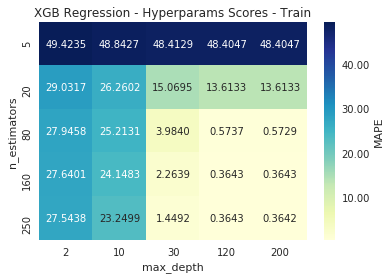

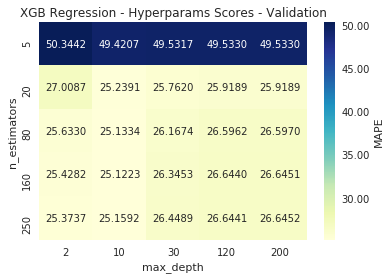

Best hyperparam value:  {'max_depth': 10, 'n_estimators': 160} Best Train Score:  24.148336549599964 Best Validation Score:  25.122276941935223
2019-06-25 16:10:02.010315  Hyperparam Tuning of XGB completed


In [24]:
param_dict_xgb_1 = {'n_estimators':[5, 20, 80, 160, 250], 
                    'max_depth':[2, 10, 30, 120, 200]}

print(datetime.now() ,' Hyperparam Tuning of XGB started')
hyp_tuned_info_xgb_1 = get_best_hyperparam_XGBRegressor(param_dict_xgb_1, X_train, y_train)
print(datetime.now() ,' Hyperparam Tuning of XGB completed')

In [25]:
best_hyp_xgb_1, best_train_score, best_validation_score, best_mse_train, best_mse_validation = hyp_tuned_info_xgb_1

### Step 2 : Train model with best hyperparam

In [26]:
# declare model
print(datetime.now() ,' Training of XGB started')
xgb_model_1 = XGBRegressor(n_estimators=best_hyp_xgb_1['n_estimators'], 
                           max_depth=best_hyp_xgb_1['max_depth'])
xgb_model_1.fit(X_train, y_train)
print(datetime.now() ,' Training of XGB completed')

# save model to disk
pickle_out = open("./model/xgb_reg1.pkl","wb")
pickle.dump(xgb_model_1, pickle_out)
pickle_out.close()

2019-06-25 16:10:02.517546  Training of XGB started
2019-06-25 16:12:55.171481  Training of XGB completed


### Step 3 : Evaluate model

In [27]:
#load model from disk
pickle_in = open("./model/xgb_reg1.pkl","rb")
xgb_model_1 = pickle.load(pickle_in)
pickle_in.close()

# performace of model
train_mse_xgb_1, train_mape_xgb_1 = evaluate_model(xgb_model_1, X_train, y_train, prefix='Train')
test_mse_xgb_1, test_mape_xgb_1 = evaluate_model(xgb_model_1, X_test, y_test, prefix='Test')

Train -> MSE:0.651300 	 MAPE:24.019100
Test -> MSE:1.148000 	 MAPE:32.749500


## Plot Feature Importance

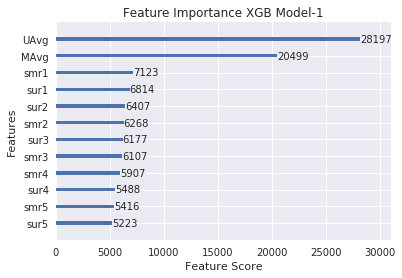

In [28]:
xgboost.plot_importance(xgb_model_1, title='Feature Importance XGB Model-%d'%(1,), 
                        xlabel='Feature Score',)
plt.show()

## B2) XGB with 13 features + BaselineOnly feature

### Adding the  as feature to X_train, X_test

In [29]:
# Surprise baseline model predictions
X_train['F_BaselineOnly'] = results_dict_bsl['train']['predictions']
X_test['F_BaselineOnly'] = results_dict_bsl['test']['predictions']
X_test.head()

,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,F_BaselineOnly
0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.500000,3.409039,3.476408
1,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.978261,3.821851,3.822106
2,4.0,4.0,4.0,5.0,4.0,5.0,2.0,2.0,5.0,2.0,2.978261,4.080811,3.980199
3,3.0,4.0,2.0,3.0,3.0,3.0,4.0,4.0,5.0,4.0,4.000000,3.617293,4.271171
4,2.0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.914894,2.854015,3.377190


### Step 1. Find best hyperparameter

2019-06-25 16:13:13.338634  Hyperparam Tuning of XGB started


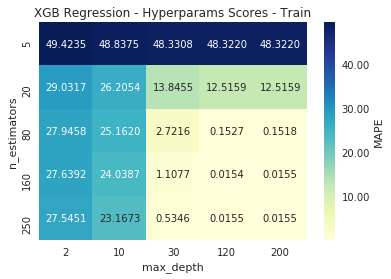

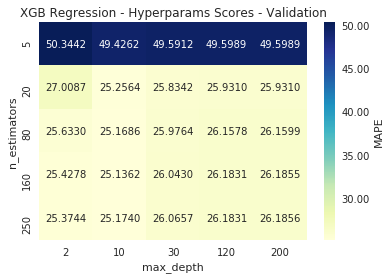

Best hyperparam value:  {'max_depth': 10, 'n_estimators': 160} Best Train Score:  24.03871814409892 Best Validation Score:  25.13616681098938
2019-06-25 21:23:07.745464  Hyperparam Tuning of XGB completed


In [30]:
param_dict_xgb_2 = {'n_estimators':[5, 20, 80, 160, 250], 
                    'max_depth':[2, 10, 30, 120, 200]}

print(datetime.now() ,' Hyperparam Tuning of XGB started')
hyp_tuned_info_xgb_2 = get_best_hyperparam_XGBRegressor(param_dict_xgb_2, X_train, y_train)
print(datetime.now() ,' Hyperparam Tuning of XGB completed')

In [31]:
best_hyp_xgb_2, best_train_score, best_validation_score, best_mse_train, best_mse_validation = hyp_tuned_info_xgb_2

### Step 2 : Train model with best hyperparam

In [32]:
# declare model
print(datetime.now() ,'  Training of XGB started')
xgb_model_2 = XGBRegressor(n_estimators=best_hyp_xgb_2['n_estimators'], 
                           max_depth=best_hyp_xgb_2['max_depth'])
xgb_model_2.fit(X_train, y_train)
print(datetime.now() ,'  Training of XGB completed')


# save model to disk
pickle_out = open("./model/xgb_reg2.pkl","wb")
pickle.dump(xgb_model_2, pickle_out)
pickle_out.close()

2019-06-25 21:23:10.089463   Training of XGB started
2019-06-25 21:26:30.019260   Training of XGB completed


### Step 3 : Evaluate model

In [33]:
#load model from disk
pickle_in = open("./model/xgb_reg2.pkl","rb")
xgb_model_2 = pickle.load(pickle_in)
pickle_in.close()

# performace of model
train_mse_xgb_2, train_mape_xgb_2 = evaluate_model(xgb_model_2, X_train, y_train, prefix='Train')
test_mse_xgb_2, test_mape_xgb_2 = evaluate_model(xgb_model_2, X_test, y_test, prefix='Test')

Train -> MSE:0.649600 	 MAPE:24.008800
Test -> MSE:1.141800 	 MAPE:32.713600


## Plot Feature Importance

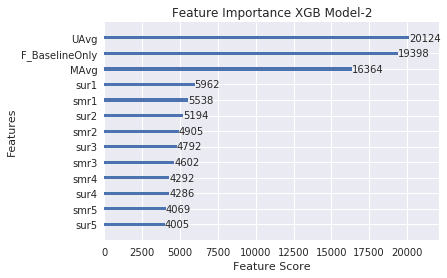

In [34]:
xgboost.plot_importance(xgb_model_2, title='Feature Importance XGB Model-%d'%(2,), 
                        xlabel='Feature Score',)
plt.show()

## B3) XGB with 13 features + BaselineOnly +  KNN Base Line features

### Adding the  as feature to X_train, X_test

In [35]:
# Surprise baseline model predictions
X_train['F_KNN_Baseline'] = results_dict_knn_bsl_m['train']['predictions']
X_test['F_KNN_Baseline'] = results_dict_knn_bsl_m['test']['predictions']
X_test.head()

,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,F_BaselineOnly,F_KNN_Baseline
0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.500000,3.409039,3.476408,2.285921
1,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.978261,3.821851,3.822106,2.570363
2,4.0,4.0,4.0,5.0,4.0,5.0,2.0,2.0,5.0,2.0,2.978261,4.080811,3.980199,2.702690
3,3.0,4.0,2.0,3.0,3.0,3.0,4.0,4.0,5.0,4.0,4.000000,3.617293,4.271171,3.074824
4,2.0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.914894,2.854015,3.377190,2.192587


### Step 1. Find best hyperparameter

2019-06-25 21:26:47.122800  Hyperparam Tuning of XGB started


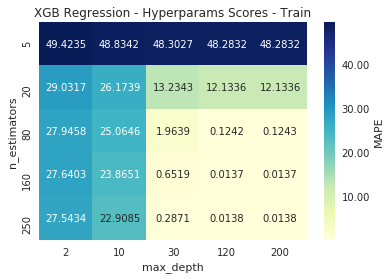

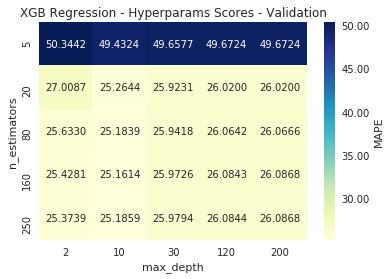

Best hyperparam value:  {'max_depth': 10, 'n_estimators': 160} Best Train Score:  23.86511166890462 Best Validation Score:  25.16142924626668
2019-06-26 02:46:49.042587  Hyperparam Tuning of XGB completed


In [36]:
param_dict_xgb_3 = {'n_estimators':[5, 20, 80, 160, 250], 
                    'max_depth':[2, 10, 30, 120, 200]}

print(datetime.now() ,' Hyperparam Tuning of XGB started')
hyp_tuned_info_xgb_3 = get_best_hyperparam_XGBRegressor(param_dict_xgb_3, X_train, y_train)
print(datetime.now() ,' Hyperparam Tuning of XGB completed')

In [37]:
best_hyp_xgb_3, best_train_score, best_validation_score, best_mse_train, best_mse_validation = hyp_tuned_info_xgb_3

### Step 2 : Train model with best hyperparam

In [38]:
# declare model
print(datetime.now() ,' Training of XGB started')
xgb_model_3 = XGBRegressor(n_estimators=best_hyp_xgb_3['n_estimators'], 
                           max_depth=best_hyp_xgb_3['max_depth'])
xgb_model_3.fit(X_train, y_train)
print(datetime.now() ,' Training of XGB completed')

# save model to disk
pickle_out = open("./model/xgb_reg3.pkl","wb")
pickle.dump(xgb_model_3, pickle_out)
pickle_out.close()

2019-06-26 02:46:51.286078  Training of XGB started
2019-06-26 02:50:40.667285  Training of XGB completed


### Step 3 : Evaluate model

In [39]:
#load model from disk
pickle_in = open("./model/xgb_reg3.pkl","rb")
xgb_model_3 = pickle.load(pickle_in)
pickle_in.close()

# performace of model
train_mse_xgb_3, train_mape_xgb_3 = evaluate_model(xgb_model_3, X_train, y_train, prefix='Train')
test_mse_xgb_3, test_mape_xgb_3 = evaluate_model(xgb_model_3, X_test, y_test, prefix='Test')

Train -> MSE:0.646500 	 MAPE:23.951900
Test -> MSE:1.143700 	 MAPE:32.750300


## Plot Feature Importance

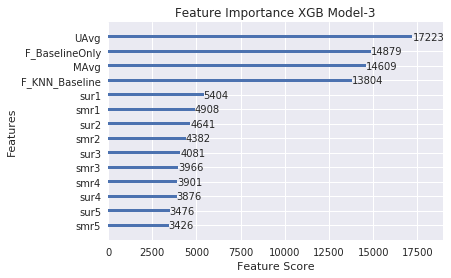

In [40]:
xgboost.plot_importance(xgb_model_3, title='Feature Importance XGB Model-%d'%(3,), 
                        xlabel='Feature Score',)
plt.show()

## B4) XGB with 13 features + BaselineOnly +  KNN Base Line + SVD Features

### Adding the  as feature to X_train, X_test

In [41]:
# Surprise baseline model predictions
X_train['F_SVD'] = results_dict_svd['train']['predictions']
X_test['F_SVD'] = results_dict_svd['test']['predictions']
X_test.head() 

,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,F_BaselineOnly,F_KNN_Baseline,F_SVD
0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.500000,3.409039,3.476408,2.285921,3.370094
1,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.978261,3.821851,3.822106,2.570363,3.803793
2,4.0,4.0,4.0,5.0,4.0,5.0,2.0,2.0,5.0,2.0,2.978261,4.080811,3.980199,2.702690,3.960326
3,3.0,4.0,2.0,3.0,3.0,3.0,4.0,4.0,5.0,4.0,4.000000,3.617293,4.271171,3.074824,4.344987
4,2.0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.914894,2.854015,3.377190,2.192587,3.003624


### Step 1. Find best hyperparameter

2019-06-26 02:50:59.575304  Hyperparam Tuning of XGB started


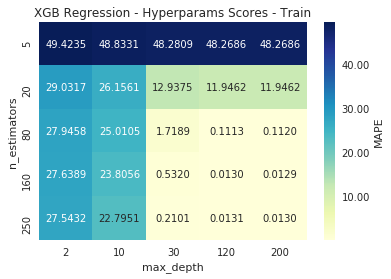

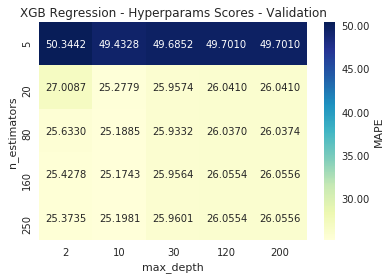

Best hyperparam value:  {'max_depth': 10, 'n_estimators': 160} Best Train Score:  23.805558681488037 Best Validation Score:  25.174277027448017
2019-06-26 08:28:27.502578  Hyperparam Tuning of XGB completed


In [42]:
param_dict_xgb_4 = {'n_estimators':[5, 20, 80, 160, 250], 
                    'max_depth':[2, 10, 30, 120, 200]}

print(datetime.now() ,' Hyperparam Tuning of XGB started')
hyp_tuned_info_xgb_4 = get_best_hyperparam_XGBRegressor(param_dict_xgb_4, X_train, y_train)
print(datetime.now() ,' Hyperparam Tuning of XGB completed')

In [43]:
best_hyp_xgb_4, best_train_score, best_validation_score, best_mse_train, best_mse_validation = hyp_tuned_info_xgb_4

### Step 2 : Train model with best hyperparam

In [44]:
# declare model
print(datetime.now() ,' Training of XGB started')
xgb_model_4 = XGBRegressor(n_estimators=best_hyp_xgb_4['n_estimators'], 
                           max_depth=best_hyp_xgb_4['max_depth'])
xgb_model_4.fit(X_train, y_train)
print(datetime.now() ,' Training of XGB completed')

# save model to disk
pickle_out = open("./model/xgb_reg4.pkl","wb")
pickle.dump(xgb_model_4, pickle_out)
pickle_out.close()

2019-06-26 08:28:29.759600  Training of XGB started
2019-06-26 08:32:50.148239  Training of XGB completed


### Step 3 : Evaluate model

In [45]:
# save model to disk
pickle_in = open("./model/xgb_reg4.pkl","rb")
xgb_model_4 = pickle.load(pickle_in)
pickle_in.close()

# performace of model
train_mse_xgb_4, train_mape_xgb_4 = evaluate_model(xgb_model_4, X_train, y_train, prefix='Train')
test_mse_xgb_4, test_mape_xgb_4 = evaluate_model(xgb_model_4, X_test, y_test, prefix='Test')

Train -> MSE:0.643700 	 MAPE:23.901200
Test -> MSE:1.142700 	 MAPE:32.731100


## Plot Feature Importance

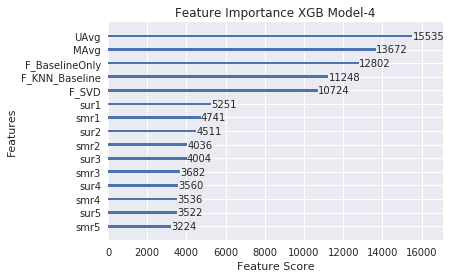

In [46]:
xgboost.plot_importance(xgb_model_4, title='Feature Importance XGB Model-%d'%(4,), 
                        xlabel='Feature Score',)
plt.show()

## B5) XGB with 13 features + BaselineOnly +  KNN Base Line + SVD + SVDpp features

### Adding the  as feature to X_train, X_test

In [47]:
# Surprise baseline model predictions
X_train['F_SVDpp'] = results_dict_svdpp['train']['predictions']
X_test['F_SVDpp'] = results_dict_svdpp['test']['predictions']
X_test.head() 

,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,F_BaselineOnly,F_KNN_Baseline,F_SVD,F_SVDpp
0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.500000,3.409039,3.476408,2.285921,3.370094,3.391509
1,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.978261,3.821851,3.822106,2.570363,3.803793,3.559892
2,4.0,4.0,4.0,5.0,4.0,5.0,2.0,2.0,5.0,2.0,2.978261,4.080811,3.980199,2.702690,3.960326,4.114547
3,3.0,4.0,2.0,3.0,3.0,3.0,4.0,4.0,5.0,4.0,4.000000,3.617293,4.271171,3.074824,4.344987,4.131854
4,2.0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.914894,2.854015,3.377190,2.192587,3.003624,3.194473


### Step 1. Find best hyperparameter

2019-06-26 08:33:09.068359  Hyperparam Tuning of XGB started


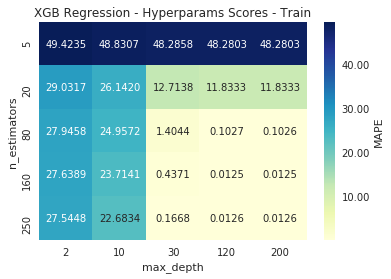

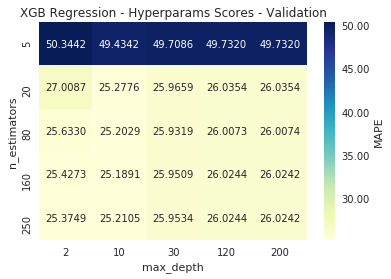

Best hyperparam value:  {'max_depth': 10, 'n_estimators': 160} Best Train Score:  23.714058597882588 Best Validation Score:  25.18907090028127
2019-06-26 14:32:35.548926  Hyperparam Tuning of XGB completed


In [48]:
param_dict_xgb_5 = {'n_estimators':[5, 20, 80, 160, 250], 
                    'max_depth':[2, 10, 30, 120, 200]}

print(datetime.now() ,' Hyperparam Tuning of XGB started')
hyp_tuned_info_xgb_5 = get_best_hyperparam_XGBRegressor(param_dict_xgb_5, X_train, 
                                                        y_train)
print(datetime.now() ,' Hyperparam Tuning of XGB completed')

In [49]:
best_hyp_xgb_5, best_train_score, best_validation_score, best_mse_train, best_mse_validation = hyp_tuned_info_xgb_5

### Step 2 : Train model with best hyperparam

In [50]:
# declare model
print(datetime.now() ,' Training of XGB started')
xgb_model_5 = XGBRegressor(n_estimators=best_hyp_xgb_5['n_estimators'], 
                           max_depth=best_hyp_xgb_5['max_depth'])
xgb_model_5.fit(X_train, y_train)
print(datetime.now() ,' Training of XGB completed')

# save model to disk
pickle_out = open("./model/xgb_reg5.pkl","wb")
pickle.dump(xgb_model_5, pickle_out)
pickle_out.close()

2019-06-26 14:32:37.800396  Training of XGB started
2019-06-26 14:37:32.455250  Training of XGB completed


### Step 3 : Evaluate model

In [51]:
#load model from disk
pickle_in = open("./model/xgb_reg5.pkl","rb")
xgb_model_5 = pickle.load(pickle_in)
pickle_in.close()

# performace of model
train_mse_xgb_5, train_mape_xgb_5 = evaluate_model(xgb_model_5, X_train, 
                                                   y_train, prefix='Train')
test_mse_xgb_5, test_mape_xgb_5 = evaluate_model(xgb_model_5, X_test,
                                                  y_test, prefix='Test')

Train -> MSE:0.644500 	 MAPE:23.926400
Test -> MSE:1.142200 	 MAPE:32.738500


## Plot Feature Importance

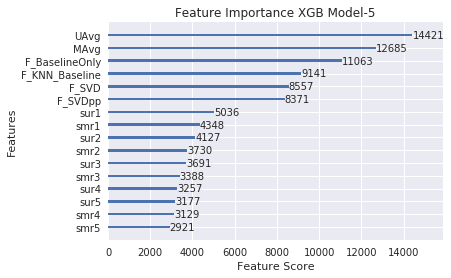

In [52]:
xgboost.plot_importance(xgb_model_5, title='Feature Importance XGB Model-%d'%(5,), 
                        xlabel='Feature Score',)
plt.show()

# Results

In [53]:
Pret_table = PrettyTable()
Pret_table.field_names = ['Model', 'Hyperparam', '# Features', 'Train MSE', 'Test MSE', 
                          'Train MAPE', 'Test MAPE']
Pret_table.title = 'Movie Ratings Results Summary'

# surprise model results
Pret_table.add_row(['BaselineOnly', '--', 13 , 
                    results_dict_bsl['train']['mse'], 
                    results_dict_bsl['test']['mse'], 
                    results_dict_bsl['train']['mape'],
                    results_dict_bsl['test']['mape']])
Pret_table.add_row(['KNN Baseline', '--', 13 ,
                    results_dict_knn_bsl_m['train']['mse'], 
                    results_dict_knn_bsl_m['test']['mse'], 
                    results_dict_knn_bsl_m['train']['mape'],
                    results_dict_knn_bsl_m['test']['mape']])
Pret_table.add_row(['SVD', '--', 13 , 
                    results_dict_svd['train']['mse'], 
                    results_dict_svd['test']['mse'], 
                    results_dict_svd['train']['mape'],
                    results_dict_svd['test']['mape']])
Pret_table.add_row(['SVDpp', '--', 13 , 
                    results_dict_svdpp['train']['mse'], 
                    results_dict_svdpp['test']['mse'], 
                    results_dict_svdpp['train']['mape'],
                    results_dict_svdpp['test']['mape']])

# XGB model results

best_hyp_xgb_1 = '\n'.join(str(best_hyp_xgb_1).split(','))
best_hyp_xgb_2 = '\n'.join(str(best_hyp_xgb_2).split(','))
best_hyp_xgb_3 = '\n'.join(str(best_hyp_xgb_3).split(','))
best_hyp_xgb_4 = '\n'.join(str(best_hyp_xgb_4).split(','))
best_hyp_xgb_5 = '\n'.join(str(best_hyp_xgb_5).split(','))


Pret_table.add_row(['XGB', best_hyp_xgb_1, 13,
                    train_mse_xgb_1, test_mse_xgb_1, 
                    train_mape_xgb_1, test_mape_xgb_1])
Pret_table.add_row(['XGB', best_hyp_xgb_2, 14,
                    train_mse_xgb_2, test_mse_xgb_2, 
                    train_mape_xgb_2, test_mape_xgb_2])
Pret_table.add_row(['XGB', best_hyp_xgb_3, 15,
                    train_mse_xgb_3, test_mse_xgb_3, 
                    train_mape_xgb_3, test_mape_xgb_3])
Pret_table.add_row(['XGB', best_hyp_xgb_4, 16,
                    train_mse_xgb_4, test_mse_xgb_4, 
                    train_mape_xgb_4, test_mape_xgb_4])
Pret_table.add_row(['XGB', best_hyp_xgb_5, 17,
                    train_mse_xgb_5, test_mse_xgb_5, 
                    train_mape_xgb_5, test_mape_xgb_5])

# 
print(Pret_table)

+---------------------------------------------------------------------------------------------------+
|                                   Movie Ratings Results Summary                                   |
+--------------+-----------------------+------------+-----------+----------+------------+-----------+
|    Model     |       Hyperparam      | # Features | Train MSE | Test MSE | Train MAPE | Test MAPE |
+--------------+-----------------------+------------+-----------+----------+------------+-----------+
| BaselineOnly |           --          |     13     |   0.8615  |  1.0458  |  28.8726   |  32.1118  |
| KNN Baseline |           --          |     13     |   0.2478  |  1.0643  |  14.0426   |  31.7234  |
|     SVD      |           --          |     13     |   0.4543  |  1.0334  |  20.0957   |  31.3857  |
|    SVDpp     |           --          |     13     |   0.4364  |  1.0355  |  19.3678   |  31.1285  |
|     XGB      |    {'max_depth': 10   |     13     |   0.6513  |  1.148   |  24.0

# Procedure Summary

<ul>
<li> Surprise library model is used as a baseline model </li>
<li> Multiple datasets are constructed by getting the predictions from surprise libray models </li>
<li> Hyperparameter tuning is done for XGB models on all the datasets created </li>
<li> XGB models are trained with the best hyperparam values </li>
<li> XGB models performace evaluated using the test dataset </li>
</ul>

# Conclusion

<ul>
<li> The best MAPE value obatined is 31.1285 from baseline SVDpp </li>
<li> The best XGB model gave 32.7136 MAPE with 14 features dataset </li>
<li> More feature engineering can be done to improve XGB models output further </li>
<li> Other models can be tried instead of XGB models </li>
</ul>